In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../..") # Adds the module to path

# DeepTrack 2.1 - Introduction

This tutorial gives an overview of how to use DeepTrack 2.1.

### What is DeepTrack 2.1?

DeepTrack 2.1 is a software that provides a comprehensive framework for digital microscopy enhanced by deep learning. In this tutorial we'll use the example of tracking a single particle to demonstrate how to effecively use deeptrack.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np
u = dt.units

## 1. Generate images

In order to train and validate deep-learning models to be used in digital microcopy, we need to generate synthetic images. For example, these images may be like the output of a digital video micoscopy experiment, where we want to track some particles.

In DeepTrack 2.0, any image can be viewed as a series of **features** applied in a sequence. Each feature takes an input image and updates it according to an **update rule**. For example, a feature can add a particle, introduce some noise, or image something through an optical device.

### Features and properties

In DeepTrack 2.0, these features are classes implementing the class `Feature` (see also [features_example](../examples/features_example.ipynb)). The way a feature updates an image is determined by the values passed to the class constructor. These inputs are converted to **properties** (see also [properties_example](../examples/properties_example.ipynb)). For example, a property could be the position of a particle. 

For example, the code below creates a feature: a point particle implemented by the class `PointParticle` with properties `position=(0, 0)`, and `intensity=100`. We use `u.pixel` to denote the unit of the property. Most of the time (such as here) this can be omitted.

In [3]:
particle = dt.PointParticle(
    position=(0, 0) * u.pixel,
    intensity=100
)

The above feature is completely deterministic so that the particle will always be at position (0, 0). For machine learning, it may be more useful to add a particle at a random position. This can be done by passing a lambda function that returns a pair of random numbers to the property `position`.

In [4]:
IMAGE_SIZE = 64

particle = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE * u.pixel,
    intensity=100
)

A point particle on its own does not make much sense when thinking of actual experiments. In order retrieve an image, we need to define also the optical device through which it is viewed. In DeepTrack 2.1, optical devices are features that convolve the input image with a pupil function. Here, we will use a fluorescence microscope `fluorescence_microscope`, which is implemented by the feature `Fluorescence` (see also [optics_example](../examples/optics_example.ipynb)). 

By calling the fluorescence microscope `fluorescence_microscope` with the point particle `particle`, we create a new feature which resolves the image of the particle as seen through the fluorescence microscope.

In [5]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.8,
    wavelength=680 * u.nm,
    magnification=10,
    resolution=1 * u.micrometer,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE)
)

imaged_particle = fluorescence_microscope(particle)

We can finally create the image of the particle by calling the feature `imaged_particle()` and plot it.

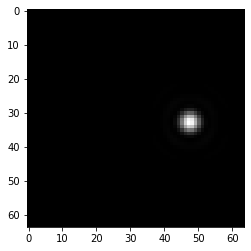

In [6]:
output_image = imaged_particle()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

As a shorthand for this, you can also call plot on the feature directly.

<AxesSubplot:>

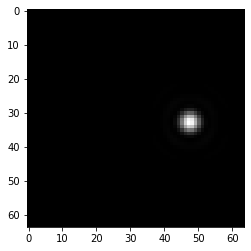

In [7]:
imaged_particle.plot(cmap="gray")

You might have noticed that, even though the position of the particle is random, it doesn't change if you refresh the cell. This is because the value of the particle position is stored as a property of the particle, useful for example to know the ground truth value of the particle position to train a deep-learning model.

If you want the particle position to change each time you refresh the cell, you need to call the method `imaged_particle.update()` before resolving the image.

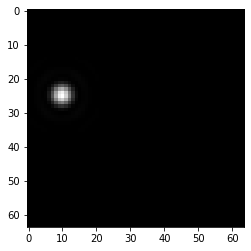

In [8]:
imaged_particle.update().plot(cmap='gray')
plt.show()

### Creating a pipeline

The power of feature is the ability to chain them! The most common way to chain features is through the pipe operator (`>>`). This will take the output of the feature on the left and pass it as input to the feature on the right! For example, here's how to add noise to the image!

<AxesSubplot:>

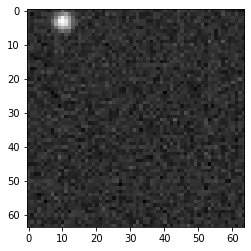

In [9]:
# The & operator

noisy_image = imaged_particle >> dt.Gaussian(sigma=0.01)
noisy_image.update().plot(cmap="gray")

Features can also cleanly interact with things that are not features! For example, arithmatic operators or functions!

<AxesSubplot:>

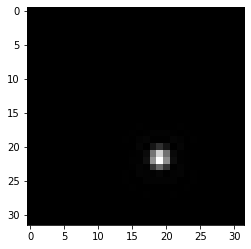

In [10]:
# Arithmatic
inverted_particle = 1 - imaged_particle 
inverted_particle.update().plot(cmap="gray")

# Function
sqrt_of_particle = imaged_particle >> np.sqrt
sqrt_of_particle.update().plot(cmap="gray")

# Indexing
downsampled_particle = imaged_particle[::2, ::2]
downsampled_particle.update().plot(cmap="gray")

There are also a few special operators, noteably the `^` operator and the `&` operator. The `^` operator is a handly tool for evaluating a feature multiple times. Note that each time it is evaluated, it will use a new set of properties. As such, it is a very convenient way to resolve multiple particles!

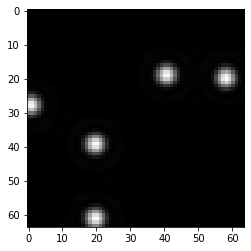

In [11]:
# # The ^ operator

particle = dt.PointParticle(
    position=lambda: (np.random.rand(2) * IMAGE_SIZE),
    intensity=1
)

five_particles = particle^5

# five_particles is a feature that resolves five instances of particle, then images it
imaged_five_particles = fluorescence_microscope(five_particles)


output_image = imaged_five_particles.update().plot(cmap="gray")


Bringing it all together, we can create a nice experimental image of multiple particles!

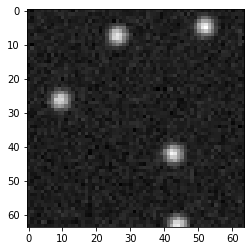

In [12]:
experimental_image = fluorescence_microscope(particle^5) + 0.1 >> dt.Poisson(snr=7, background=0.1)
output_image = experimental_image.update().plot(cmap="gray")

The `&` will be demonstrated in detail later in this example. But know for now that is a way to stack the outputs of multiple features.

## 2. Retrieve information about the image

To train a supervised machine-learning model, labelled images are needed. When a feature is resolved, it automatically stores the properties of all features used to create the image. This allows us to extract information about the image, for example, in order to use them to train machine-learning models. We show two ways of getting a list of positions of all particles in the image.

Here, we extract the position of all the particles and plot them as red crosses on the generated image.

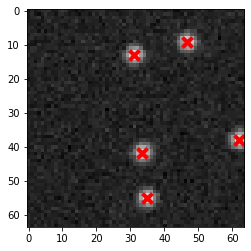

In [13]:
def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = [property_dict["position"] for property_dict in image.properties if "position" in property_dict]
    # Alternatively
    positions = image.get_property("position", get_one=False)
    return np.array(positions)

output_image = experimental_image.update()()

positions = get_positions(output_image)

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(positions[:, 1], positions[:, 0], c="r", s=100, linewidths=4, marker="x")
plt.show()

Now, we want a pipeline that returns both the image and the positions of the particles. For this we can use the `&` operator.

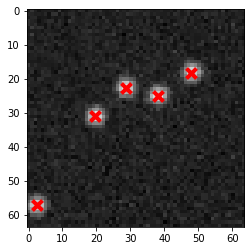

In [14]:
position_feature = experimental_image >> get_positions
image_and_position = experimental_image & position_feature

output_image, positions = image_and_position.update()()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(positions[:, 1], positions[:, 0], c="r", s=100, linewidths=4, marker="x")
plt.show()

Here, we first create a feature that extracts the positions in the image, and then we "stack" them using the `&` operator. The result is a feature that first calls `experimental_image()` and then `get_positions(experimental_image())`, and returns both results. Don't worry, DeepTrack 2.1 makes sure that `experimental_image` will not be executed twice unless absolutely needed!

## 3. Training the model

We are finally ready to create a deep-learning model to track the particles.
We will use a convolutional neural network implemented by the function `convolutional` (see also [models_example](../examples/models_example.ipynb)) to track point particles (`particle`) imaged through a fluorescence microscope (`fluorescence_microscope`) with some noise (`offset` and `poisson_noise`). We will furthermore use the feature `NormalizeMinMax` to normalize the dynamic range of the images btween 0 and 1.

This model is designed to track a single particle with a high accuracy. It is not well suited for the task of multi-particle tracking.

In [26]:
# DEFINE LABEL FUNCTION
def get_position(image):
    return image.get_property("position") - IMAGE_SIZE / 2
        
# DEFINE MODEL
model = dt.models.Convolutional(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), number_of_outputs=2, loss="mae")

# DEFINE TRAINING SET
particle = dt.PointParticle(position=lambda: IMAGE_SIZE / 2 + np.random.randn(2) * 2)
training_data = fluorescence_microscope(particle) >> dt.NormalizeMinMax()
training_set = training_data & (training_data >> get_position)

Since we've defined the `training_set` as a feature that returns the data and the label simultaneously, we can train the model by passing it the feature directly! For more control on exactly how the model is trained, please see the next guide on how to use `generators`.

In [27]:
model.fit(training_set, batch_size=16, epochs=100)

Generating 321 / 320 samples before starting training
Epoch 1/100
20/20 [==============================] - 1s 6ms/step - loss: 1.3696
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5477
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3499
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.2376
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2604
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2128
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1869
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1670
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1611
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1253
Epoch 11/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1616
Epoch 12/100
20/20 [==============================] - 0s 7ms/ste

Finally, we test the trained model on some newly generated images. We can extract a batch from the generator directly

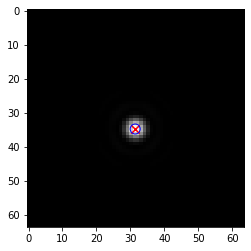

In [38]:

image, true_position = training_set.update()()
measured_positions = model.predict(image[np.newaxis])[0] + IMAGE_SIZE / 2

plt.imshow(image, cmap='gray')
plt.scatter(true_position[1] + IMAGE_SIZE / 2, true_position[0] + IMAGE_SIZE / 2, s=70, c='r', marker='x')
plt.scatter(measured_positions[1], measured_positions[0], s=100, marker='o', facecolor='none', edgecolors='b')
plt.show()